In [27]:
! pip install tensorflow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [28]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Example optimizer usage
opt = Adam(learning_rate=0.001)

In [29]:
#load the dataset

train = loadmat('/kaggle/input/svhndataset/train_32x32.mat')
test = loadmat('/kaggle/input/svhndataset/test_32x32.mat')

In [30]:
train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [31]:
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [32]:
train_img = np.array(train['X'])
test_img = np.array(test['X'])

train_label = train['y']
test_label = test['y']

In [33]:
train_img = np.moveaxis(train_img, -1, 0)
test_img = np.moveaxis(test_img, -1, 0)
print(train_img.shape)
print(test_img.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


# **Plotting function**

In [34]:
plt.rcParams["figure.figsize"] = (20,3)
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0], cmap='gray')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

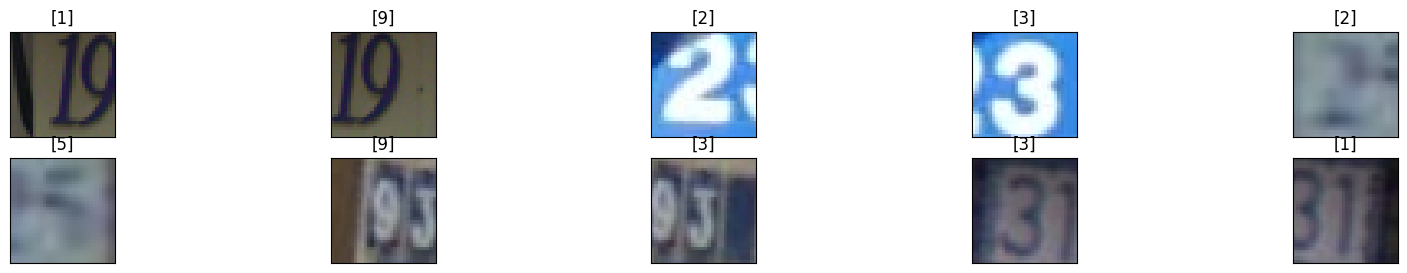

In [35]:
plot_images(train_img, train_label, 2, 5)

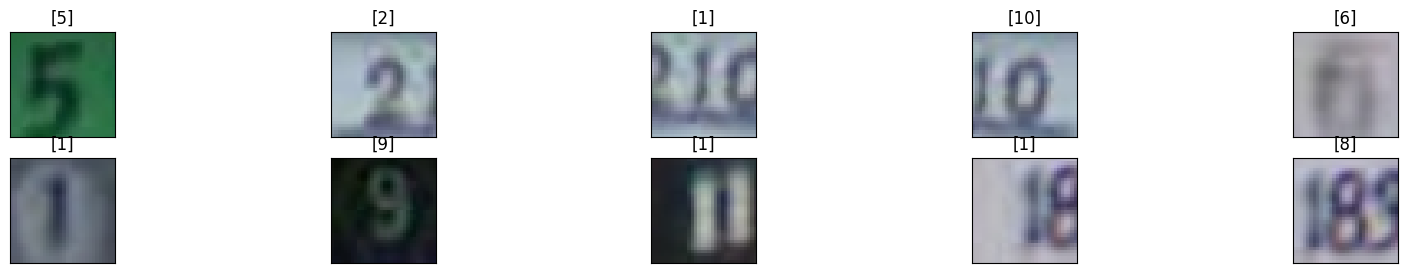

In [36]:
plot_images(test_img, test_label, 2, 5)

In [37]:
np.unique(train_label)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [38]:
train_label[train_label == 10] = 0
test_label[test_label == 10] = 0

In [39]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2989, 0.5870, 0.1140]), axis=3)

In [40]:
X_train = rgb2gray(train_img).astype(np.float32)
X_test = rgb2gray(test_img).astype(np.float32)

In [41]:
print("Training Set", X_train.shape)
print("Test Set", X_test.shape)

Training Set (73257, 32, 32, 1)
Test Set (26032, 32, 32, 1)


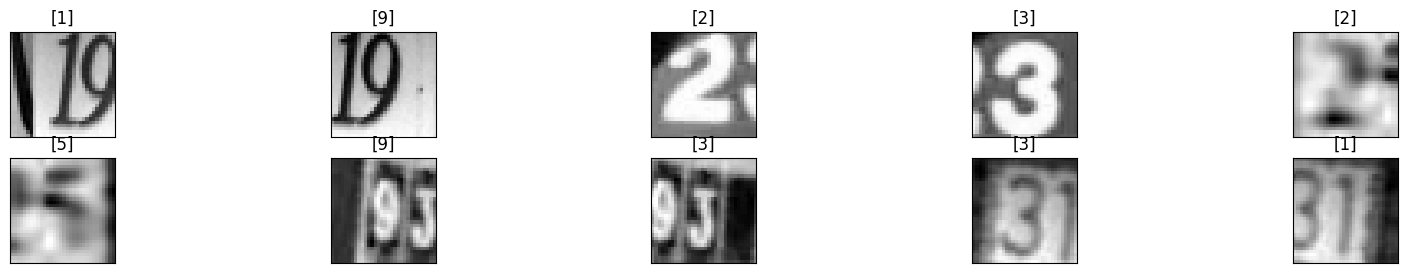

In [42]:
plot_images(X_train, train_label, 2, 5)

In [43]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(test_label)

In [44]:
print(y_train[5])

[0 0 0 0 0 1 0 0 0 0]


In [45]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(73257, 32, 32, 1)
(73257, 10)
(26032, 32, 32, 1)
(26032, 10)


# Model


In [47]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,32,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3),  activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3),  activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,855,818 (71.93 MB)

 Trainable params: 18,854,346 (71.92 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [48]:
from tensorflow.keras.optimizers import Adam

# Initialize the Adam optimizer
opt = Adam(learning_rate=0.001)


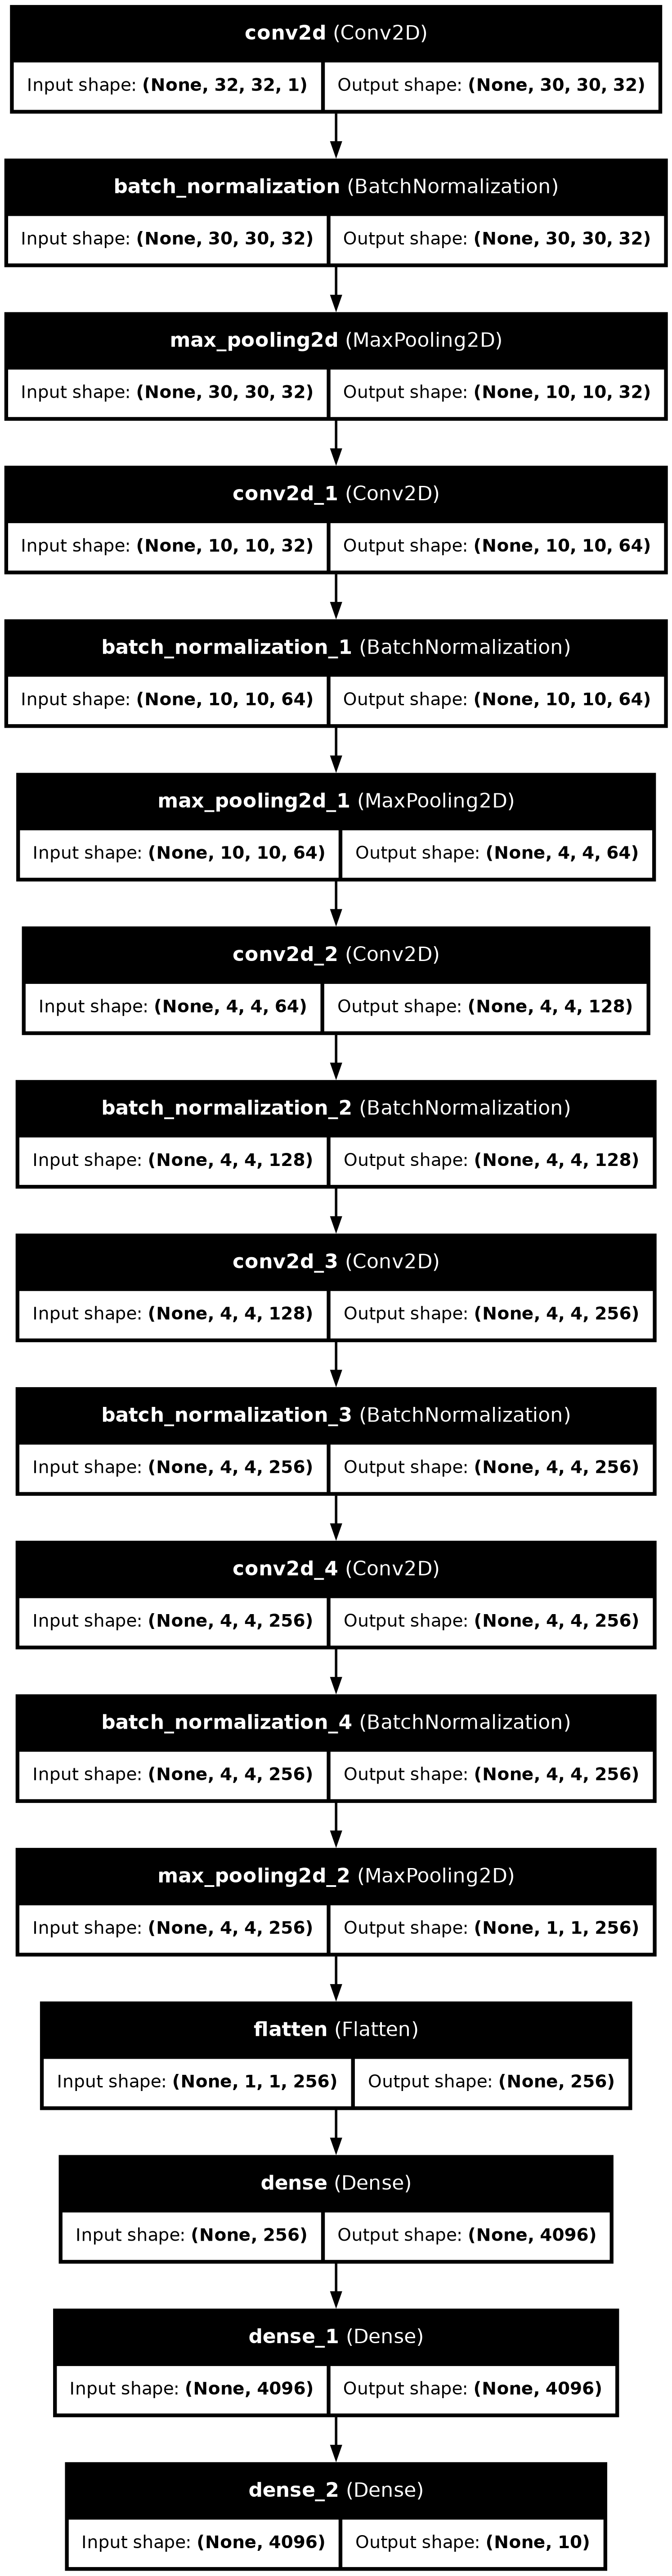

In [49]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [50]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

In [51]:
r = model.fit(
  X_train,y_train,
  validation_data=(X_test, y_test),
  epochs=30
)

Epoch 1/30


I0000 00:00:1728027588.098139      98 service.cc:145] XLA service 0x7dd404018470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728027588.098192      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  28/2290 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.1033 - loss: 5.1969 

I0000 00:00:1728027592.023752      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2290/2290 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.6345 - loss: 1.1894 - val_accuracy: 0.8563 - val_loss: 0.4740
Epoch 2/30
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8835 - loss: 0.3883 - val_accuracy: 0.8862 - val_loss: 0.3804
Epoch 3/30
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9087 - loss: 0.3090 - val_accuracy: 0.8890 - val_loss: 0.3706
Epoch 4/30
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9233 - loss: 0.2631 - val_accuracy: 0.9186 - val_loss: 0.2927
Epoch 5/30
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9354 - loss: 0.2165 - val_accuracy: 0.8790 - val_loss: 0.4275
Epoch 6/30
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9437 - loss: 0.1893 - val_accuracy: 0.9122 - val_loss: 0.3163
Epoch 7/30
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9531 - loss: 0.1608 - val_accuracy: 0.9192 - val_loss: 0.2950
Epoch 8/30
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9603 - loss: 0.1345 - val

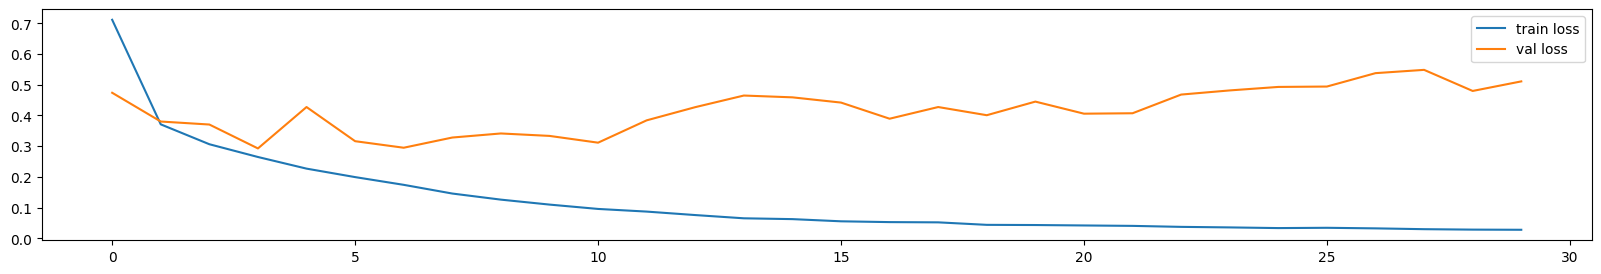

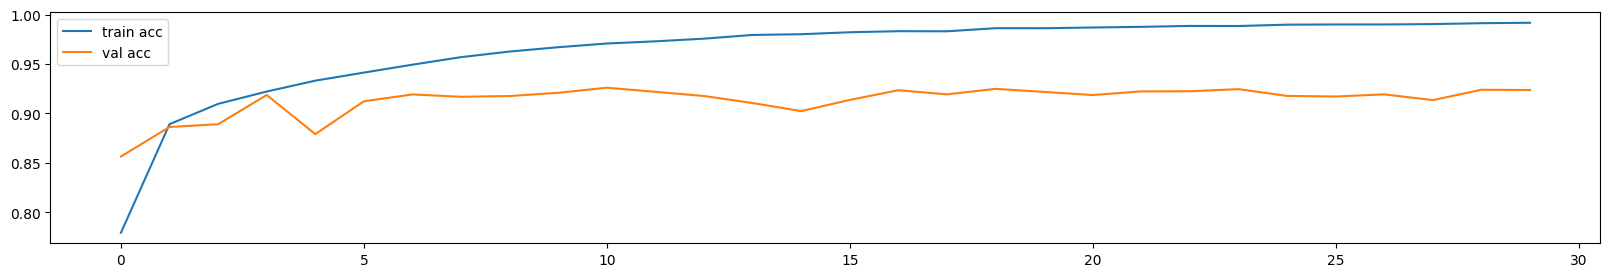

<Figure size 2000x300 with 0 Axes>

In [52]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [70]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


Overall Accuracy: 92.36%


In [73]:
# Calculate precision (macro-averaged, micro-averaged, and per-class if needed)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score

precision_macro = precision_score(y_true, y_pred_classes, average='macro')
precision_micro = precision_score(y_true, y_pred_classes, average='micro')
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Precision (Micro): {precision_micro:.4f}")

Precision (Macro): 0.9182
Precision (Micro): 0.9236


In [55]:
y_pred = model.predict(X_test)  # Predictions for test set
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)  # True class labels for the test set

# Similarly for validation data if needed:
# y_val_pred = model.predict(X_val)  # if you have validation data


814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


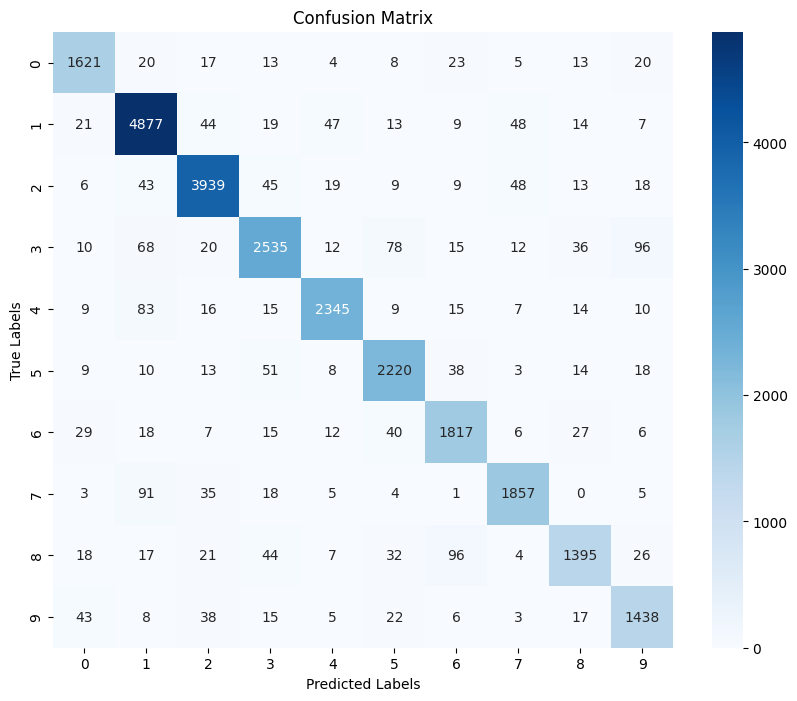

In [66]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [67]:
# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      1744
           1       0.93      0.96      0.94      5099
           2       0.95      0.95      0.95      4149
           3       0.92      0.88      0.90      2882
           4       0.95      0.93      0.94      2523
           5       0.91      0.93      0.92      2384
           6       0.90      0.92      0.91      1977
           7       0.93      0.92      0.93      2019
           8       0.90      0.84      0.87      1660
           9       0.87      0.90      0.89      1595

    accuracy                           0.92     26032
   macro avg       0.92      0.92      0.92     26032
weighted avg       0.92      0.92      0.92     26032



In [74]:
import seaborn as sns
import numpy as np
import tensorflow as tf

# For plotting top 10 predictions
def plot_top_predictions(images, true_labels, predicted_labels, predictions, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
    axes = axes.ravel()
    
    for i in range(nrows * ncols):
        img_idx = i
        ax = axes[i]
        ax.imshow(images[img_idx].squeeze(), cmap='gray')
        true_label = np.argmax(true_labels[img_idx])
        pred_label = np.argmax(predicted_labels[img_idx])
        pred_confidence = np.max(predictions[img_idx])
        ax.set_title(f'True: {true_label}, Pred: {pred_label}\nConfidence: {pred_confidence:.2f}')
        ax.axis('off')

    plt.tight_layout()
plt.show()

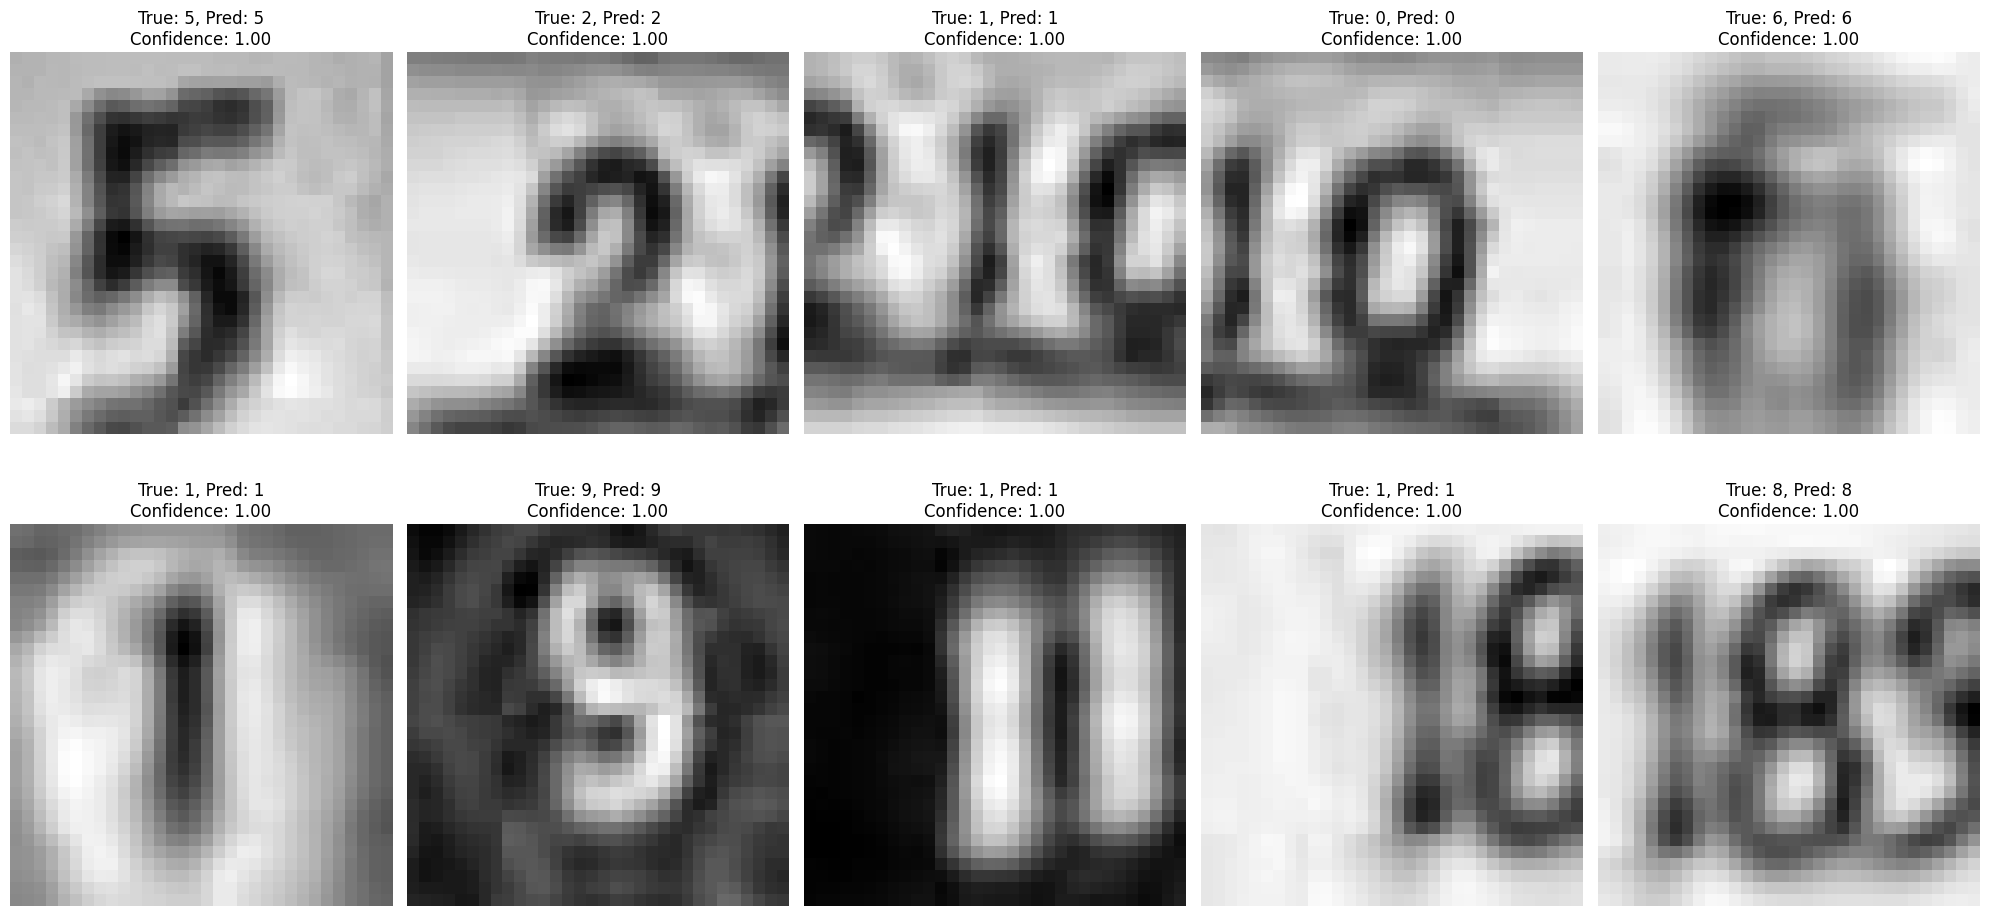

In [75]:
# Plot top 10 predictions (for test set)
plot_top_predictions(X_test, y_test, y_pred, y_pred, nrows=2, ncols=5)


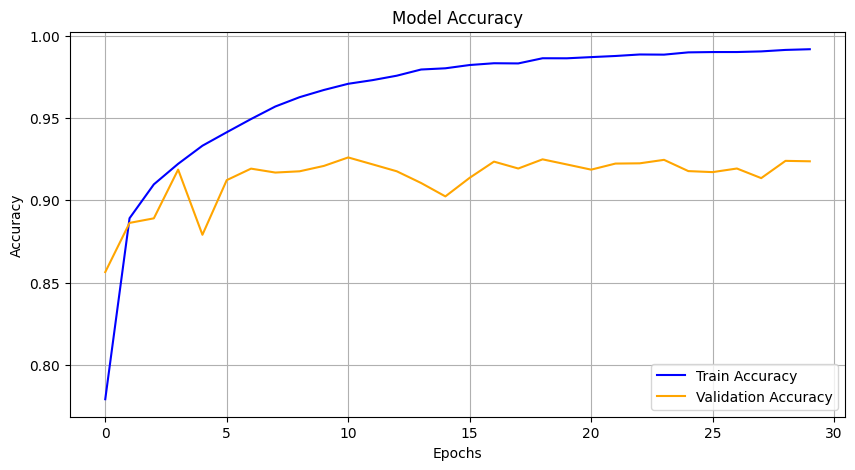

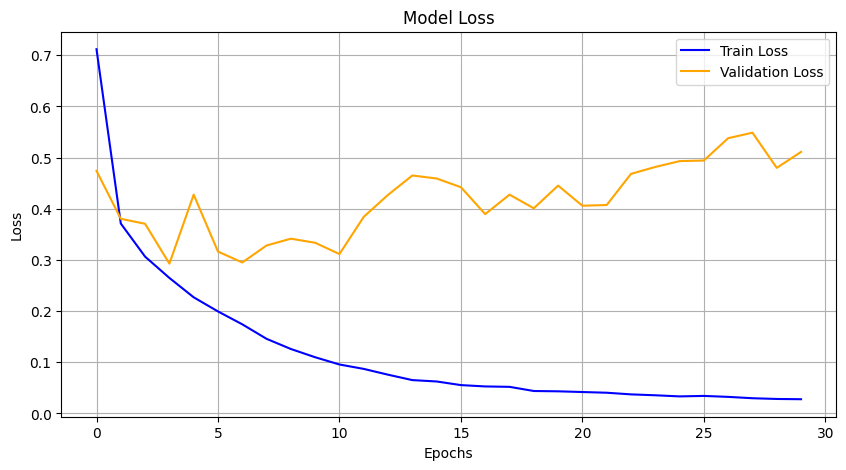

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(r.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Separate plot for Loss
plt.figure(figsize=(10, 5))
plt.plot(r.history['loss'], label='Train Loss', color='blue')
plt.plot(r.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

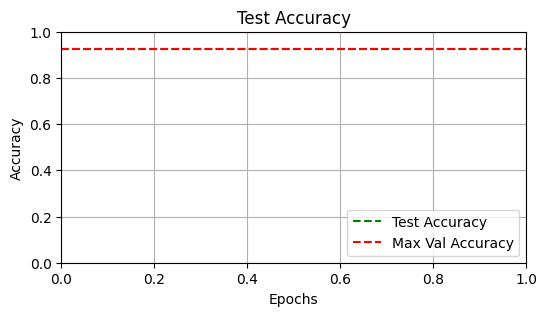

In [81]:
# Separate plots for Test Metrics
# Test accuracy plot
plt.figure(figsize=(6, 3))
plt.axhline(y=accuracy, color='green', linestyle='--', label='Test Accuracy')
plt.axhline(y=np.max(r.history['val_accuracy']), color='red', linestyle='--', label='Max Val Accuracy')
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [82]:
# Calculate test loss
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]  # Only get loss
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.5111
